In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v2, resnet18
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader, Dataset

import numpy as np

from sklearn.metrics import accuracy_score

In [2]:
CUDA = 0

def get_cls_model(input_shape):
    """
    :param input_shape: tuple (n_rows, n_cols, n_channels)
            input shape of image for classification
    :return: nn model for classification
    """
    device = torch.device(f'cuda:{CUDA}' if torch.cuda.is_available() else 'cpu')
    model = mobilenet_v2(pretrained=False)
    
    downsample_coef = 224 * 224 // 1280
    fc_size = input_shape[0] * input_shape[1] * input_shape[2] // downsample_coef
    
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier = nn.Sequential(
        #nn.Linear(1280, 512),
        #nn.BatchNorm1d(512),
        #nn.ReLU(),
        #nn.Linear(512, 256),
        #nn.BatchNorm1d(256),
        #nn.ReLU(),
        nn.Linear(1280, 2)
    )
    model = model.to(device)
    return model

In [3]:
from sklearn.model_selection import train_test_split
import os

In [4]:
data = np.load('tests/00_unittest_classifier_input/train_data.npz')
X = data['X'].reshape(-1, 1, 40, 100)   #pytorch dimensions are (N, C, H, W)
y = data['y'].astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

In [8]:
from tqdm.notebook import tqdm

class SaveBestModel:
    def __init__(self, best_val_loss=np.inf):
        self.best_val_loss = best_val_loss
        
    def __call__(self, val_loss, epoch, model, optimizer, scheduler=None, model_path='model/best_model.pth'):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else {}
                }, model_path
            )
            print('New best model with loss {:.5f} is saved'.format(val_loss))

def save_model(epoch, model, optimizer, model_path='model/final_model.pth'):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, model_path
    )
    print('Model is saved')
    
def load_model(model, optimizer, scheduler=None, model_path='model/best_model.pth'):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    if scheduler:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    return model, optimizer, epoch, scheduler

            
def train_epoch(model, optimizer, criterion, train_loader, device, tqdm_desc):
    model.train()
    train_acc, train_loss = 0.0, 0.0

    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_acc += (logits.argmax(dim=1) == labels).sum().item()
        train_loss += loss.item() * labels.shape[0]

    train_acc /= len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)

    return train_acc, train_loss


@torch.no_grad()
def val_epoch(model, criterion, val_loader, device, tqdm_desc):
    model.eval()
    val_acc, val_loss = 0.0, 0.0

    for images, labels in tqdm(val_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        val_acc += (logits.argmax(dim=1) == labels).sum().item()
        val_loss += loss.item() * labels.shape[0]

    val_acc /= len(val_loader.dataset)
    val_loss /= len(val_loader.dataset)

    return val_acc, val_loss


def train(model, optimizer, criterion, scheduler, train_loader, val_loader, device, num_epochs, model_saver, continue_training=True, model_path='model/best_model.pth', start_epoch=0):
    
    if continue_training:
        model, optimizer, start_epoch, scheduler = load_model(model, optimizer, scheduler, model_path)
    
    for epoch in range(start_epoch + 1, num_epochs + 1):
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_loader, device, f'Training epoch {epoch}/{num_epochs}')
        val_acc, val_loss = val_epoch(model, criterion, val_loader, device, f'Validating epoch {epoch}/{num_epochs}')

        if scheduler is not None:
            scheduler.step(val_loss)
        
        print({'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})
        model_saver(val_loss, epoch, model, optimizer, scheduler, model_path)


In [439]:
CUDA = 0

class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        device = torch.device(f'cuda:{CUDA}' if torch.cuda.is_available() else 'cpu')
        model = resnet18(pretrained=False)

        model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        model.avgpool = nn.Identity()
        model.fc = nn.Sequential(
            nn.Linear(4096, 2),
            #nn.BatchNorm1d(256),
            #nn.ReLU(),
            #nn.Linear(256, 128),
            #nn.BatchNorm1d(128),
            #nn.ReLU(),
            #nn.Linear(128, 2)
        )
        
        model = model.to(device)
        self.model = model
        
        
    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.fc(x)

        return x
    
def get_cls_model(input_shape):
    """
    :param input_shape: tuple (n_rows, n_cols, n_channels)
            input shape of image for classification
    :return: nn model for classification
    """
    device = torch.device(f'cuda:{CUDA}' if torch.cuda.is_available() else 'cpu')
    return ClassificationModel()


def train_epoch(model, optimizer, criterion, train_loader, device):
    model.train()
    train_acc, train_loss = 0.0, 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_acc += (logits.argmax(dim=1) == labels).sum().item()
        train_loss += loss.item() * labels.shape[0]

    train_acc /= len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)

    return train_acc, train_loss


def train(model, optimizer, criterion, scheduler, train_loader, device, num_epochs):

    for epoch in range(1, num_epochs + 1):
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_loader, device)

        if scheduler is not None:
            scheduler.step()


def fit_cls_model(X, y):
    """
    :param X: 4-dim tensor with training images
    :param y: 1-dim tensor with labels for training
    :return: trained nn model
    """
    # your code here \/
    model = get_cls_model((40, 100, 1))

    train_transform = T.Compose([
        T.RandomHorizontalFlip(),
        #T.RandomRotation((-5,5)),
        T.Normalize(mean=0.5, std=0.5),
    ])

    batch_size = 32

    train_dataset = TensorDataset(train_transform(X), y)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    scheduler = None

    n_epochs = 10
    device = torch.device(f'cuda:{CUDA}' if torch.cuda.is_available() else 'cpu')

    train(model, optimizer, criterion, scheduler, train_dataloader, device, n_epochs)

    return model.cpu()

model = fit_cls_model(X_train, y_train)
y_predicted = torch.argmax(model.cpu()(X_test), dim=1)
accuracy_score(y_test, y_predicted)

C:\Users\kirill-korolev\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kirill-korolev\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


0.9885931558935361

In [345]:
#torch.save(model, 'classifier_model.pth')

In [440]:
import copy

def linear_to_conv(layer):
    out_channels = 2
    in_channels = 512
    kernel_size = (2, 4)
    
    weights = layer.state_dict()['weight'][:].view(out_channels, in_channels, kernel_size[0], kernel_size[1])
    bias = layer.state_dict()['bias'][:]

    conv = nn.Conv2d(in_channels=512, out_channels=2, kernel_size=kernel_size, bias=True)
    conv.state_dict()['weight'][:] = weights
    conv.state_dict()['bias'][:] = bias

    return conv

class DetectionModel(nn.Module):
    def __init__(self, cls_model):
        super().__init__()
        self.cls_model = copy.deepcopy(cls_model)
        self.cls_model.model.fc[0] = linear_to_conv(self.cls_model.model.fc[0])
        
        
    def forward(self, x):
        model = self.cls_model.model
        
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)
        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.avgpool(x)
        
        x = model.fc(x)

        return x

In [441]:
def get_detection_model(cls_model):
    """
    :param cls_model: trained cls model
    :return: fully convolutional nn model with weights initialized from cls
             model
    """
    return DetectionModel(cls_model).double()

In [442]:
from common import read_for_detection

In [480]:
test_dir = 'tests/04_unittest_detector_input/'
img_dir = os.path.join(test_dir, 'test_imgs')
gt_path = os.path.join(test_dir, 'true_detections.json')
images_detection = read_for_detection(img_dir, gt_path)

images_detection_no_answer = {}
images_detection_only_bboxes = {}
for img_name, data in images_detection.items():
    images_detection_no_answer[img_name] = data[0]
    images_detection_only_bboxes[img_name] = data[1]

In [493]:
x = torch.randn(1,1,220,370).to(device)
model.to(device)(x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x43008 and 4096x2)

In [461]:
detection_model = get_detection_model(model).to(device)

In [445]:
from skimage.io import imshow
import matplotlib.pyplot as plt

In [482]:
def get_detections(detection_model, dictionary_of_images):
    """
    :param detection_model: trained fully convolutional detector model
    :param dictionary_of_images: dictionary of images in format
        {filename: ndarray}
    :return: detections in format {filename: detections}. detections is a N x 5
        array, where N is number of detections. Each detection is described
        using 5 numbers: [row, col, n_rows, n_cols, confidence].
    """
    detections_dict = {}
    threshold = 5
    
    nrows, ncols = 6, 9
    box_nrows, box_ncols = 40, 100
    
    for image_filepath, orig_image in list(dictionary_of_images.items()):
        image = np.zeros((220, 370))
        image[:orig_image.shape[0], :orig_image.shape[1]] = orig_image

        torch_image = torch.from_numpy(image)
        torch_image = torch_image.view(1, 1, *image.shape).double()
        feature_map = detection_model(torch_image.to(device)).squeeze(dim=0).detach().cpu().numpy()

        pos_feature_map = feature_map[1,:]
        
        #imshow(image)
        #plt.show()
        #imshow(pos_feature_map)
        boxes_idxs = np.argsort(pos_feature_map.ravel())[-threshold:]

        row_indices = boxes_idxs // ncols
        col_indices = boxes_idxs % ncols
        
        row = row_indices * box_nrows
        col = col_indices * box_ncols
        
        detections = np.stack((row, col, np.full(threshold, box_nrows), np.full(threshold, box_ncols), pos_feature_map[row_indices, col_indices]), axis=1)

        detections_dict[image_filepath] = detections

    return detections_dict

torch.Size([83, 142])


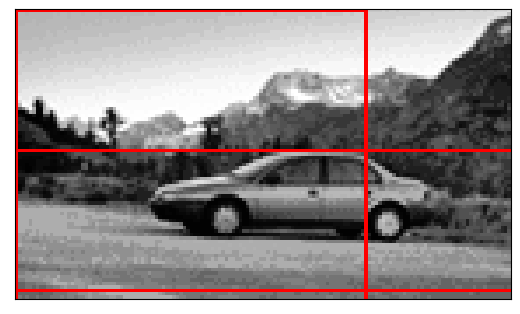

In [489]:
for img_name, data in list(images_detection.items())[5:]:
    image = torch.from_numpy((255 * data[0]).astype(np.uint8))
    print(image.shape)
    bboxes = data[1]
    bboxes_coords = boxes_to_coords(bboxes)
    
    predicted_bboxes = detections[img_name]
    predicted_coords = boxes_to_coords(predicted_bboxes[:,:4])
    
    show(draw_bounding_boxes(image.view(1, *image.shape), torch.Tensor(predicted_coords), colors='red'))
    break

In [483]:
detections = get_detections(detection_model, images_detection_no_answer)

In [364]:
def get_detections2(detection_model, dictionary_of_images):
    """
    :param detection_model: trained fully convolutional detector model
    :param dictionary_of_images: dictionary of images in format
        {filename: ndarray}
    :return: detections in format {filename: detections}. detections is a N x 5
        array, where N is number of detections. Each detection is described
        using 5 numbers: [row, col, n_rows, n_cols, confidence].
    """
    detections_dict = {}
    threshold = 3
    n_rows, n_cols = 7, 12

    width = 370
    height = 220
    
    box_height = height // n_rows
    box_width = width // n_cols
    
    
    for image_filepath, orig_image in list(dictionary_of_images.items())[1:]:
        #image = np.zeros((height, width))
        #image[:orig_image.shape[0], :orig_image.shape[1]] = orig_image
        print(orig_image.shape)
        orig_image = np.random.randn(40, 100)
        torch_image = torch.from_numpy(orig_image)
        torch_image = torch_image.view(1, 1, *orig_image.shape).double()
        feature_map = detection_model(torch_image).squeeze(dim=0).detach().numpy()
        
        print(feature_map.shape)
        break

model = model.double()
get_detections2(detection_model, images_detection_no_answer)

(137, 275)
(2, 2, 4)


In [294]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F

In [295]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [330]:
def boxes_to_coords(bboxes):
    bboxes_coords = []

    for box in bboxes:
        row, col, nrows, ncols = box
        
        xmin = col
        xmax = xmin + ncols
        
        ymin = row
        ymax = ymin + nrows
        
        bboxes_coords.append([xmin, ymin, xmax, ymax])
    
    return bboxes_coords

In [479]:
#draw_bounding_boxes(image, boxes, labels, colors=colors, width=5)

for img_name, data in list(images_detection.items())[1:]:
    image = torch.from_numpy((255 * data[0]).astype(np.uint8))
    print(image.shape)
    bboxes = data[1]
    bboxes_coords = boxes_to_coords(bboxes)
    
    predicted_bboxes = detections[img_name]
    predicted_coords = boxes_to_coords(predicted_bboxes[:,:4])
    
    show(draw_bounding_boxes(image.view(1, *image.shape), torch.Tensor(predicted_coords), colors='red'))
    break

torch.Size([137, 275])


KeyError: 'test-1.png'